## Лабораторная работа №5
#### *Прудникова Анастасия М8О-408Б-20*
*Вариант 24*


Целью работы является исследование свойств сетей Хопфилда, Хэмминга и Элмана, алгоритмов обучения, а также применение сетей в задачах распознавания статических и динамических
образов.
Основные этапы работы:
1. Использовать сеть Элмана для распознавания динамических образов. Проверить качество распознавания.
2. Использовать сеть Хопфилда для распознавания статических образов. Проверить качество распознавания.
3. Использовать сеть Хэмминга для распознавания статических образов. Проверить качество распознавания.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

In [16]:
class Duration:
    def __init__(self) -> None:
        self.r1 = 3
        self.r2 = 4
        self.r3 = 6
        
R = Duration()

In [17]:
def make_signals(r1, r2, r3):
    k1 = np.arange(0, 1, 0.025) 
    k2 = np.arange(2.84, 6.25, 0.025)

    p1 =  np.sin(4 * np.pi * k1) 
    p2 = np.cos((k2) ** 2 - 10 * k2 + 3)

    t1 = -1 * np.ones(len(p1))
    t2 = np.ones(len(p2))

    assert len(k1) == len(p1) and len(k1) == len(t1)
    assert len(k2) == len(p2) and len(k2) == len(t2)

    signal = np.concatenate((np.tile(p1, r1), p2, np.tile(p1, r2), p2, np.tile(p1, r3), p2))
    labels = np.concatenate((np.tile(t1, r1), t2, np.tile(t1, r2), t2, np.tile(t1, r3), t2))

    return signal, labels

In [18]:
def get_train_data(signal, labels, window):
    signal_seq = [np.array(signal[i:i+window], dtype=np.float32) for i in range(len(signal) - window)]
    labels_seq = [np.array(labels[i:i+window], dtype=np.float32) for i in range(len(labels) - window)]
    output = [(s, l) for s, l in zip(signal_seq, labels_seq)]
    return output

In [19]:
signal, labels = make_signals(R.r1, R.r2, R.r3)
WINDOW = 5

train_dataset = get_train_data(signal, labels, WINDOW)
train_loader = DataLoader(train_dataset, shuffle=False)

In [20]:
# класс слоя сети Элмана
class ElmanLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super(ElmanLayer, self).__init__()
        self.weights1 = nn.Parameter(torch.randn(in_features, out_features))
        self.weights2 = nn.Parameter(torch.randn(out_features, out_features))
        self.bias = nn.Parameter(torch.randn(out_features))

    def reset(self):
        if hasattr(self, "prev"):
            delattr(self, "prev")

    def forward(self, input: torch.Tensor):
        out = torch.matmul(input, self.weights1)
        out = torch.add(out, self.bias)
        if hasattr(self, "prev"):
            d = torch.matmul(self.prev, self.weights2)
            out = torch.add(out, d)
        out = torch.tanh(out) # outp -> [-1, 1]
        self.prev = out.clone().detach()
        return out

In [21]:
def fit(model, train_loader, criterion, optimizer, epochs):
    losses = []

    running_loss = 0.0
    processed_data = 0

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            model[0].reset() 
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outp = model(inputs)

                loss = criterion(outp, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                processed_data += inputs.size(0)

            train_loss = running_loss / processed_data
            losses.append(train_loss)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=loss))
    return losses

In [22]:
elman_net = nn.Sequential (
    ElmanLayer(in_features = WINDOW, out_features = 8),
    nn.Linear(in_features = 8, out_features = WINDOW)
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(elman_net.parameters())

In [23]:
def predict(model, test_loader):
    with torch.no_grad():
        model.eval()
        model[0].reset()
        outp = []
        for x, _ in test_loader:
            outp += [model(x).detach().numpy().item(0)]
        outp = np.array(outp)

        outp[outp > 0] = 1
        outp[outp < 0] = -1
    return outp

In [24]:
losses = fit(elman_net, train_loader, loss_function, optimizer, 100)


epoch:   1%|          | 1/100 [00:01<02:31,  1.53s/it]


Epoch 001 train_loss: 0.4492


epoch:   2%|▏         | 2/100 [00:03<02:28,  1.52s/it]


Epoch 002 train_loss: 0.5404


epoch:   3%|▎         | 3/100 [00:05<02:47,  1.72s/it]


Epoch 003 train_loss: 0.8181


epoch:   4%|▍         | 4/100 [00:06<02:43,  1.70s/it]


Epoch 004 train_loss: 1.4448


epoch:   5%|▌         | 5/100 [00:08<02:34,  1.63s/it]


Epoch 005 train_loss: 1.1013


epoch:   6%|▌         | 6/100 [00:09<02:28,  1.58s/it]


Epoch 006 train_loss: 1.3638


epoch:   7%|▋         | 7/100 [00:11<02:24,  1.56s/it]


Epoch 007 train_loss: 2.2705


epoch:   8%|▊         | 8/100 [00:12<02:23,  1.55s/it]


Epoch 008 train_loss: 2.0108


epoch:   9%|▉         | 9/100 [00:14<02:24,  1.59s/it]


Epoch 009 train_loss: 1.3495


epoch:  10%|█         | 10/100 [00:15<02:21,  1.57s/it]


Epoch 010 train_loss: 0.2162


epoch:  11%|█         | 11/100 [00:17<02:21,  1.59s/it]


Epoch 011 train_loss: 0.1378


epoch:  12%|█▏        | 12/100 [00:19<02:23,  1.63s/it]


Epoch 012 train_loss: 0.0446


epoch:  13%|█▎        | 13/100 [00:20<02:20,  1.61s/it]


Epoch 013 train_loss: 0.1053


epoch:  14%|█▍        | 14/100 [00:22<02:20,  1.63s/it]


Epoch 014 train_loss: 1.1380


epoch:  15%|█▌        | 15/100 [00:24<02:15,  1.60s/it]


Epoch 015 train_loss: 0.6467


epoch:  16%|█▌        | 16/100 [00:25<02:13,  1.59s/it]


Epoch 016 train_loss: 0.3607


epoch:  17%|█▋        | 17/100 [00:27<02:09,  1.56s/it]


Epoch 017 train_loss: 0.0170


epoch:  18%|█▊        | 18/100 [00:28<02:05,  1.54s/it]


Epoch 018 train_loss: 0.0064


epoch:  19%|█▉        | 19/100 [00:30<02:04,  1.53s/it]


Epoch 019 train_loss: 0.0030


epoch:  20%|██        | 20/100 [00:31<02:03,  1.55s/it]


Epoch 020 train_loss: 0.0013


epoch:  21%|██        | 21/100 [00:33<02:04,  1.58s/it]


Epoch 021 train_loss: 0.0065


epoch:  22%|██▏       | 22/100 [00:34<02:03,  1.59s/it]


Epoch 022 train_loss: 0.0073


epoch:  23%|██▎       | 23/100 [00:36<02:00,  1.57s/it]


Epoch 023 train_loss: 0.0008


epoch:  24%|██▍       | 24/100 [00:38<01:59,  1.57s/it]


Epoch 024 train_loss: 0.0004


epoch:  25%|██▌       | 25/100 [00:39<01:56,  1.55s/it]


Epoch 025 train_loss: 0.1303


epoch:  26%|██▌       | 26/100 [00:41<01:52,  1.53s/it]


Epoch 026 train_loss: 0.0054


epoch:  27%|██▋       | 27/100 [00:42<01:55,  1.58s/it]


Epoch 027 train_loss: 0.0092


epoch:  28%|██▊       | 28/100 [00:44<01:55,  1.60s/it]


Epoch 028 train_loss: 0.0255


epoch:  29%|██▉       | 29/100 [00:45<01:53,  1.60s/it]


Epoch 029 train_loss: 0.0445


epoch:  30%|███       | 30/100 [00:47<01:50,  1.58s/it]


Epoch 030 train_loss: 0.0003


epoch:  31%|███       | 31/100 [00:49<01:48,  1.57s/it]


Epoch 031 train_loss: 0.0214


epoch:  32%|███▏      | 32/100 [00:50<01:47,  1.58s/it]


Epoch 032 train_loss: 0.0180


epoch:  33%|███▎      | 33/100 [00:52<01:49,  1.64s/it]


Epoch 033 train_loss: 0.0130


epoch:  34%|███▍      | 34/100 [00:54<01:47,  1.63s/it]


Epoch 034 train_loss: 0.0094


epoch:  35%|███▌      | 35/100 [00:55<01:49,  1.68s/it]


Epoch 035 train_loss: 0.0077


epoch:  36%|███▌      | 36/100 [00:57<01:42,  1.60s/it]


Epoch 036 train_loss: 0.0072


epoch:  37%|███▋      | 37/100 [00:58<01:41,  1.61s/it]


Epoch 037 train_loss: 0.0076


epoch:  38%|███▊      | 38/100 [01:00<01:46,  1.72s/it]


Epoch 038 train_loss: 0.0085


epoch:  39%|███▉      | 39/100 [01:02<01:45,  1.73s/it]


Epoch 039 train_loss: 0.0096


epoch:  40%|████      | 40/100 [01:04<01:49,  1.82s/it]


Epoch 040 train_loss: 0.0109


epoch:  41%|████      | 41/100 [01:06<01:44,  1.77s/it]


Epoch 041 train_loss: 0.0118


epoch:  42%|████▏     | 42/100 [01:07<01:39,  1.71s/it]


Epoch 042 train_loss: 0.0279


epoch:  43%|████▎     | 43/100 [01:09<01:39,  1.74s/it]


Epoch 043 train_loss: 0.0332


epoch:  44%|████▍     | 44/100 [01:11<01:46,  1.90s/it]


Epoch 044 train_loss: 0.0279


epoch:  45%|████▌     | 45/100 [01:13<01:44,  1.91s/it]


Epoch 045 train_loss: 0.0458


epoch:  46%|████▌     | 46/100 [01:15<01:40,  1.86s/it]


Epoch 046 train_loss: 0.1077


epoch:  47%|████▋     | 47/100 [01:17<01:36,  1.82s/it]


Epoch 047 train_loss: 0.0468


epoch:  48%|████▊     | 48/100 [01:19<01:35,  1.84s/it]


Epoch 048 train_loss: 0.0654


epoch:  49%|████▉     | 49/100 [01:21<01:32,  1.82s/it]


Epoch 049 train_loss: 0.0340


epoch:  50%|█████     | 50/100 [01:22<01:27,  1.76s/it]


Epoch 050 train_loss: 0.0498


epoch:  51%|█████     | 51/100 [01:24<01:23,  1.71s/it]


Epoch 051 train_loss: 0.0503


epoch:  52%|█████▏    | 52/100 [01:25<01:20,  1.68s/it]


Epoch 052 train_loss: 0.0396


epoch:  53%|█████▎    | 53/100 [01:28<01:25,  1.83s/it]


Epoch 053 train_loss: 0.0246


epoch:  54%|█████▍    | 54/100 [01:29<01:20,  1.75s/it]


Epoch 054 train_loss: 0.0025


epoch:  55%|█████▌    | 55/100 [01:31<01:17,  1.73s/it]


Epoch 055 train_loss: 0.0071


epoch:  56%|█████▌    | 56/100 [01:33<01:20,  1.83s/it]


Epoch 056 train_loss: 0.0622


epoch:  57%|█████▋    | 57/100 [01:34<01:14,  1.74s/it]


Epoch 057 train_loss: 0.0716


epoch:  58%|█████▊    | 58/100 [01:36<01:11,  1.71s/it]


Epoch 058 train_loss: 0.2970


epoch:  59%|█████▉    | 59/100 [01:38<01:09,  1.70s/it]


Epoch 059 train_loss: 0.0859


epoch:  60%|██████    | 60/100 [01:39<01:08,  1.71s/it]


Epoch 060 train_loss: 0.1207


epoch:  61%|██████    | 61/100 [01:41<01:04,  1.66s/it]


Epoch 061 train_loss: 0.1217


epoch:  62%|██████▏   | 62/100 [01:43<01:04,  1.69s/it]


Epoch 062 train_loss: 0.0946


epoch:  63%|██████▎   | 63/100 [01:44<00:59,  1.62s/it]


Epoch 063 train_loss: 0.0574


epoch:  64%|██████▍   | 64/100 [01:46<00:58,  1.62s/it]


Epoch 064 train_loss: 0.0520


epoch:  65%|██████▌   | 65/100 [01:47<00:56,  1.62s/it]


Epoch 065 train_loss: 0.0608


epoch:  66%|██████▌   | 66/100 [01:49<00:55,  1.63s/it]


Epoch 066 train_loss: 0.0156


epoch:  67%|██████▋   | 67/100 [01:51<00:54,  1.65s/it]


Epoch 067 train_loss: 0.0011


epoch:  68%|██████▊   | 68/100 [01:52<00:52,  1.65s/it]


Epoch 068 train_loss: 0.0003


epoch:  69%|██████▉   | 69/100 [01:54<00:52,  1.68s/it]


Epoch 069 train_loss: 0.0003


epoch:  70%|███████   | 70/100 [01:56<00:49,  1.65s/it]


Epoch 070 train_loss: 0.0009


epoch:  71%|███████   | 71/100 [01:57<00:47,  1.63s/it]


Epoch 071 train_loss: 0.0017


epoch:  72%|███████▏  | 72/100 [01:59<00:44,  1.60s/it]


Epoch 072 train_loss: 0.0026


epoch:  73%|███████▎  | 73/100 [02:00<00:41,  1.53s/it]


Epoch 073 train_loss: 0.0016


epoch:  74%|███████▍  | 74/100 [02:02<00:39,  1.54s/it]


Epoch 074 train_loss: 0.0003


epoch:  75%|███████▌  | 75/100 [02:03<00:39,  1.57s/it]


Epoch 075 train_loss: 0.0002


epoch:  76%|███████▌  | 76/100 [02:05<00:37,  1.58s/it]


Epoch 076 train_loss: 0.0016


epoch:  77%|███████▋  | 77/100 [02:07<00:36,  1.59s/it]


Epoch 077 train_loss: 0.0053


epoch:  78%|███████▊  | 78/100 [02:08<00:34,  1.58s/it]


Epoch 078 train_loss: 0.0096


epoch:  79%|███████▉  | 79/100 [02:10<00:33,  1.59s/it]


Epoch 079 train_loss: 0.0173


epoch:  80%|████████  | 80/100 [02:11<00:31,  1.59s/it]


Epoch 080 train_loss: 0.0300


epoch:  81%|████████  | 81/100 [02:13<00:30,  1.60s/it]


Epoch 081 train_loss: 0.0359


epoch:  82%|████████▏ | 82/100 [02:15<00:28,  1.60s/it]


Epoch 082 train_loss: 0.0344


epoch:  83%|████████▎ | 83/100 [02:16<00:26,  1.55s/it]


Epoch 083 train_loss: 0.0316


epoch:  84%|████████▍ | 84/100 [02:18<00:25,  1.62s/it]


Epoch 084 train_loss: 0.0301


epoch:  85%|████████▌ | 85/100 [02:19<00:24,  1.62s/it]


Epoch 085 train_loss: 0.0287


epoch:  86%|████████▌ | 86/100 [02:21<00:22,  1.61s/it]


Epoch 086 train_loss: 0.0282


epoch:  87%|████████▋ | 87/100 [02:23<00:20,  1.61s/it]


Epoch 087 train_loss: 0.0292


epoch:  88%|████████▊ | 88/100 [02:24<00:19,  1.63s/it]


Epoch 088 train_loss: 0.0309


epoch:  89%|████████▉ | 89/100 [02:26<00:18,  1.64s/it]


Epoch 089 train_loss: 0.0308


epoch:  90%|█████████ | 90/100 [02:28<00:17,  1.73s/it]


Epoch 090 train_loss: 0.0289


epoch:  91%|█████████ | 91/100 [02:30<00:15,  1.71s/it]


Epoch 091 train_loss: 0.0293


epoch:  92%|█████████▏| 92/100 [02:31<00:13,  1.67s/it]


Epoch 092 train_loss: 0.0306


epoch:  93%|█████████▎| 93/100 [02:33<00:11,  1.69s/it]


Epoch 093 train_loss: 0.0287


epoch:  94%|█████████▍| 94/100 [02:35<00:10,  1.73s/it]


Epoch 094 train_loss: 0.0277


epoch:  95%|█████████▌| 95/100 [02:36<00:08,  1.71s/it]


Epoch 095 train_loss: 0.0248


epoch:  96%|█████████▌| 96/100 [02:38<00:06,  1.69s/it]


Epoch 096 train_loss: 0.0277


epoch:  97%|█████████▋| 97/100 [02:40<00:05,  1.68s/it]


Epoch 097 train_loss: 0.0279


epoch:  98%|█████████▊| 98/100 [02:41<00:03,  1.70s/it]


Epoch 098 train_loss: 0.0278


epoch:  99%|█████████▉| 99/100 [02:43<00:01,  1.67s/it]


Epoch 099 train_loss: 0.0298


epoch: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]


Epoch 100 train_loss: 0.0340


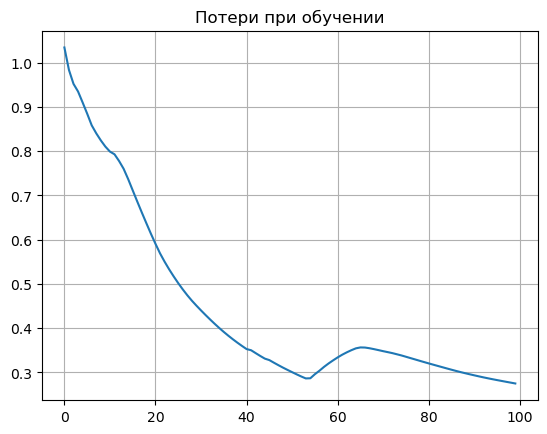

In [25]:
plt.plot(losses)
plt.grid(True, which='both')
plt.title('Потери при обучении')
plt.show()

In [26]:
labels_pred = predict(elman_net, train_loader)


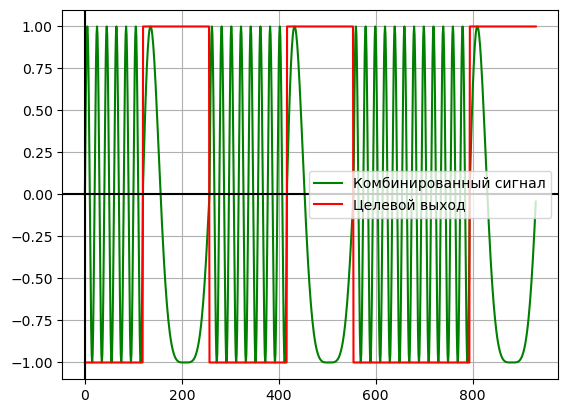

In [28]:
plt.plot(signal, label='Комбинированный сигнал', color='green')
plt.plot(labels, label='Целевой выход', color='red')

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()

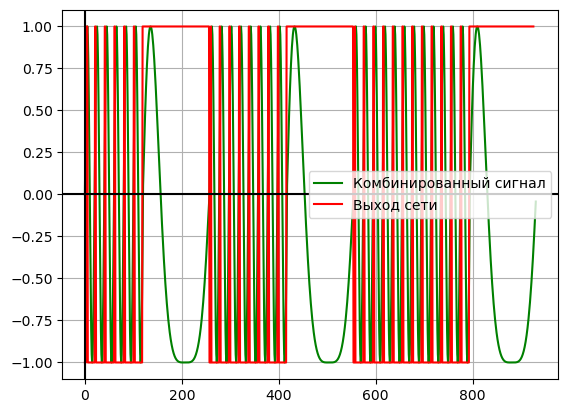

In [30]:
plt.plot(signal, label='Комбинированный сигнал', color='green')
plt.plot(labels_pred, label='Выход сети', color='red')

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()

В данной работе была выстроена сеть, включающая ретроспективные связи. Данная архитектура была применена для проблемы распознавания динамических образов. 